# AT2 - Retail dataset preperation for prediction by splitting the dataset using time based split

# 1. Loading the dataset

## 1.1. Launch commands to automatically reload modules

In [1]:
%load_ext autoreload
%autoreload 2

## 1.2. Import the packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To ensure plots are displayed in Jupyter notebooks
%matplotlib inline

## 1.3. Load the training and test dataset into a dataframes

In [3]:
# Load the training and test datasets into data frames 
# Load the Parquet files into DataFrames
df_train = pd.read_parquet('../../data/interim/price_merged_train_data.parquet')
df_test = pd.read_parquet('../../data/interim/price_merged_test_data.parquet')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        object        
 2   dept_id        object        
 3   cat_id         object        
 4   store_id       object        
 5   state_id       object        
 6   d              object        
 7   sales          int64         
 8   date           datetime64[ns]
 9   wm_yr_wk       int64         
 10  day_index      int32         
 11  day_name       object        
 12  month_name     object        
 13  event_type     object        
 14  sell_price     float64       
 15  sales_revenue  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(10)
memory usage: 4.0+ GB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160986 entries, 0 to 12160985
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        object        
 2   dept_id        object        
 3   cat_id         object        
 4   store_id       object        
 5   state_id       object        
 6   d              object        
 7   sales          int64         
 8   date           datetime64[ns]
 9   wm_yr_wk       int64         
 10  day_index      int32         
 11  day_name       object        
 12  month_name     object        
 13  event_type     object        
 14  sell_price     float64       
 15  sales_revenue  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(10)
memory usage: 1.4+ GB


## 1.4 Missing data check

In [6]:
# Check for missing values in df_train
missing_train = df_train.isnull().sum()
print("Missing values in Training Data:")
print(missing_train[missing_train > 0])  # Display only columns with missing values

# Check for missing values in df_test
missing_test = df_test.isnull().sum()
print("\nMissing values in Testing Data:")
print(missing_test[missing_test > 0])  # Display only columns with missing values

Missing values in Training Data:
Series([], dtype: int64)

Missing values in Testing Data:
Series([], dtype: int64)


# 2.0 Data Preperation 

 ## 2.1 Installing the custom package with pip

In [7]:
! pip install -i https://test.pypi.org/simple/ my_krml_pine==2024.0.1.18

Looking in indexes: https://test.pypi.org/simple/


## 2.2 import custom functions

In [8]:
from my_krml_pine.models.null import NullRegressor
from my_krml_pine.models.performance import print_regressor_scores
from my_krml_pine.data.datavisuals import plot_time_series, plot_unique_item_count

## 2.3 Visualising the dataset

### 2.3.1 visualising the sales over time

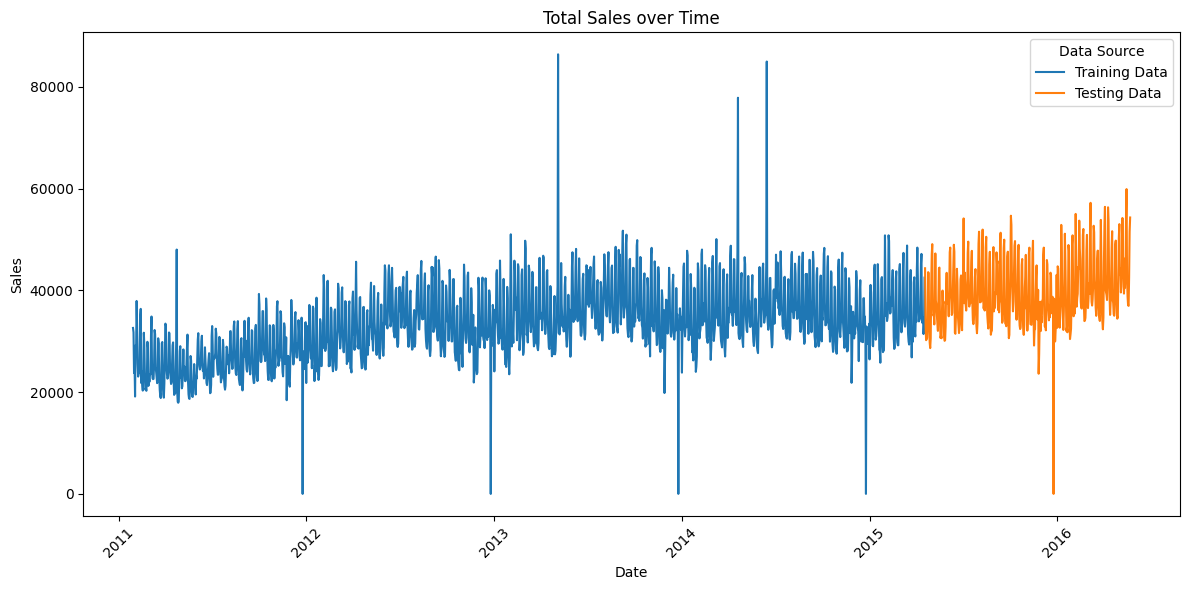

In [9]:
plot_time_series(df_train, 'date', 'sales', df_test, title='Total Sales over Time', xlabel='Date', ylabel='Sales')

### 2.3.2 Overview of the state wise - stores and items

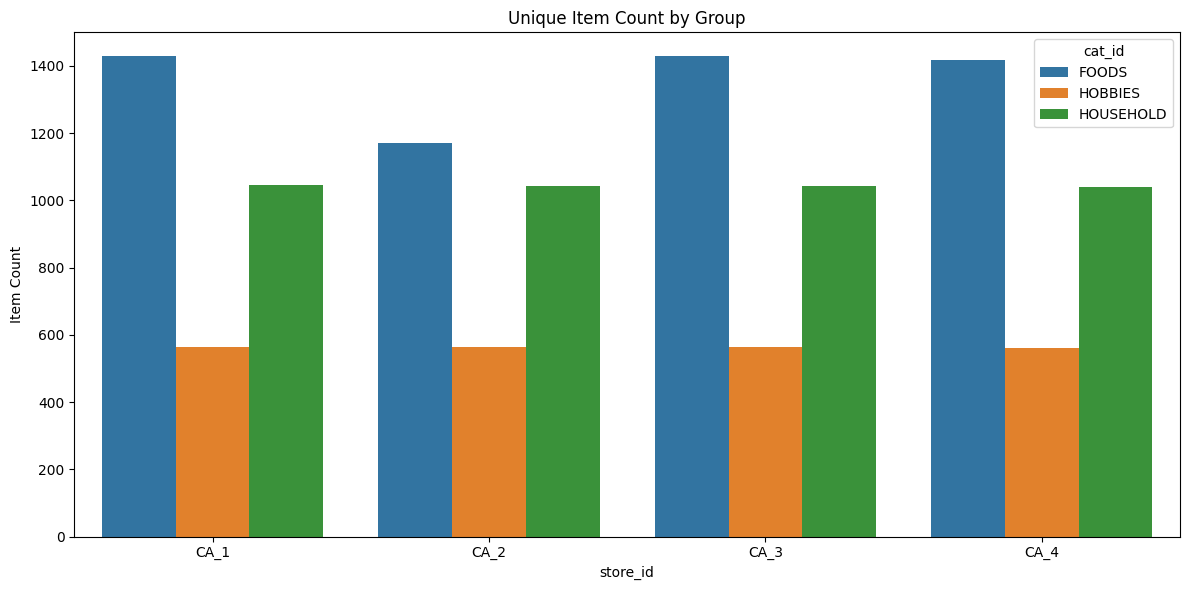

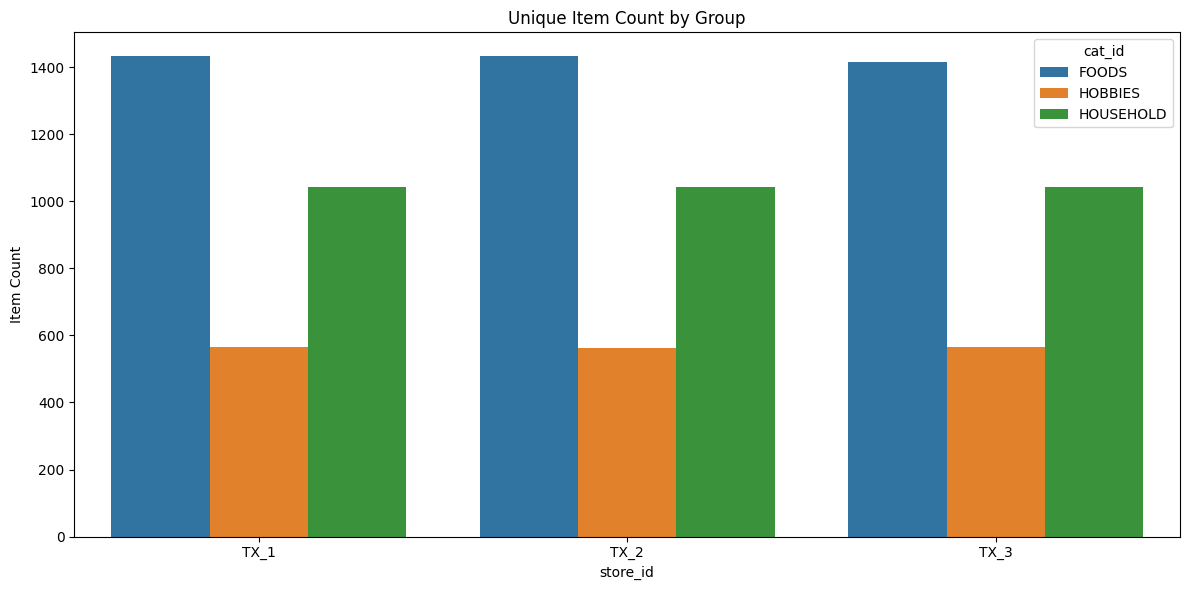

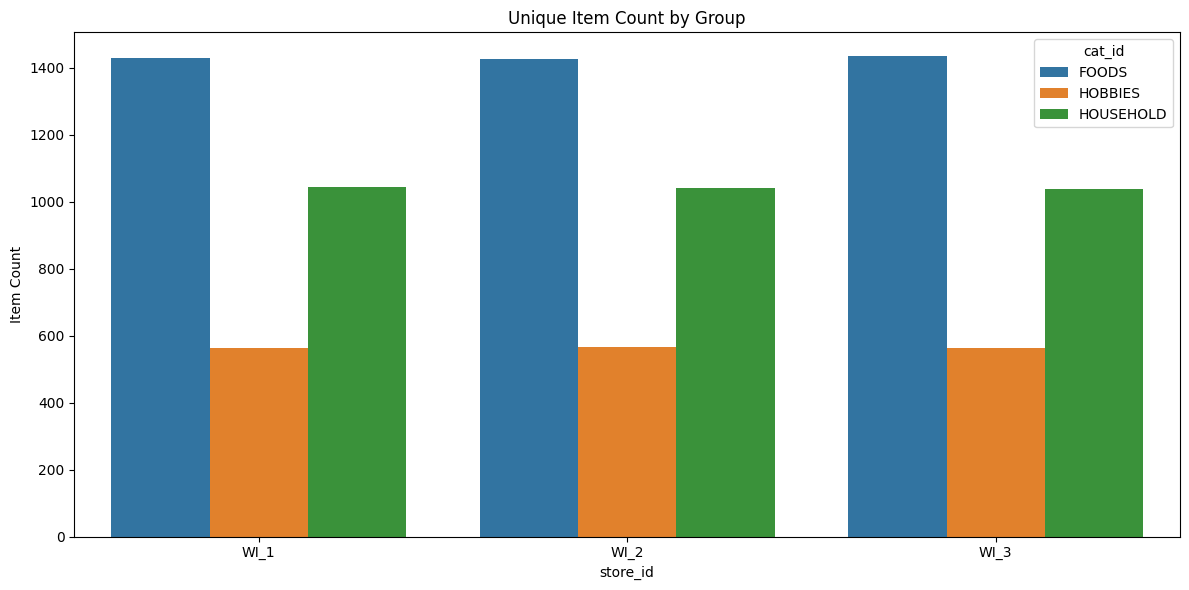

In [10]:
# Training Data
states = ['CA', 'TX', 'WI']
for state in states:
    plot_unique_item_count(df_train, ['store_id', 'cat_id'], 'item_id', 'state_id', state)


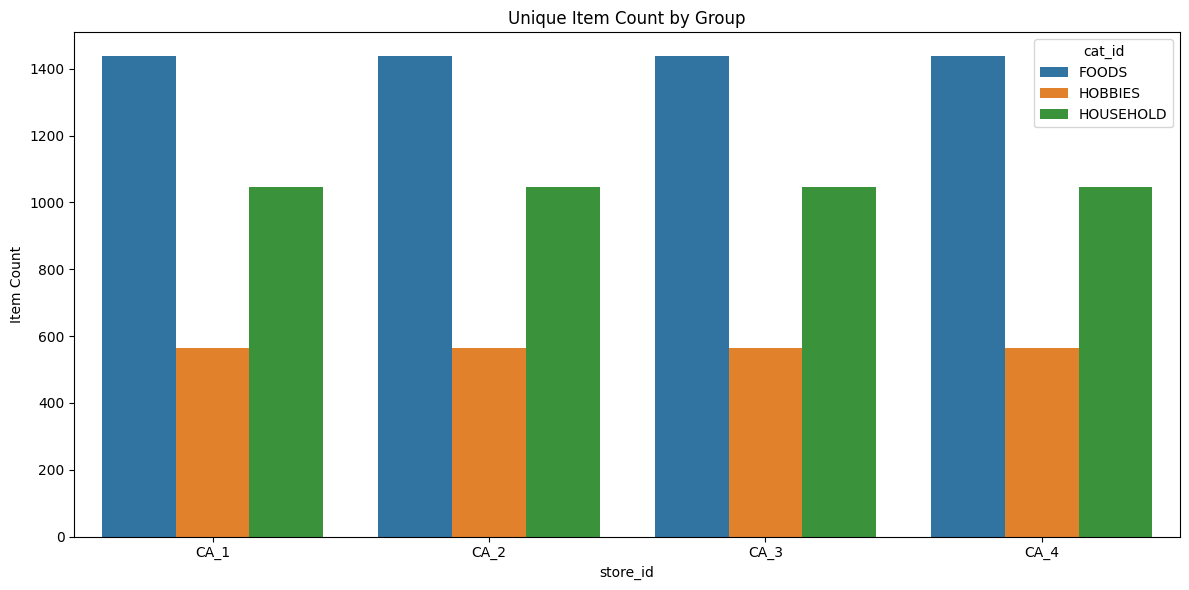

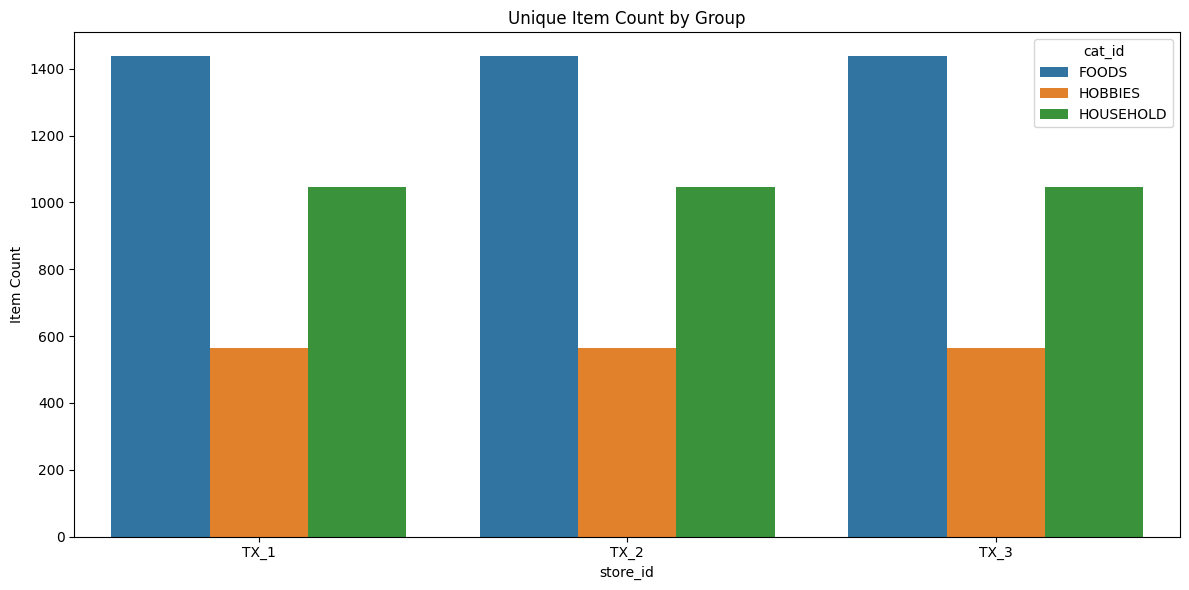

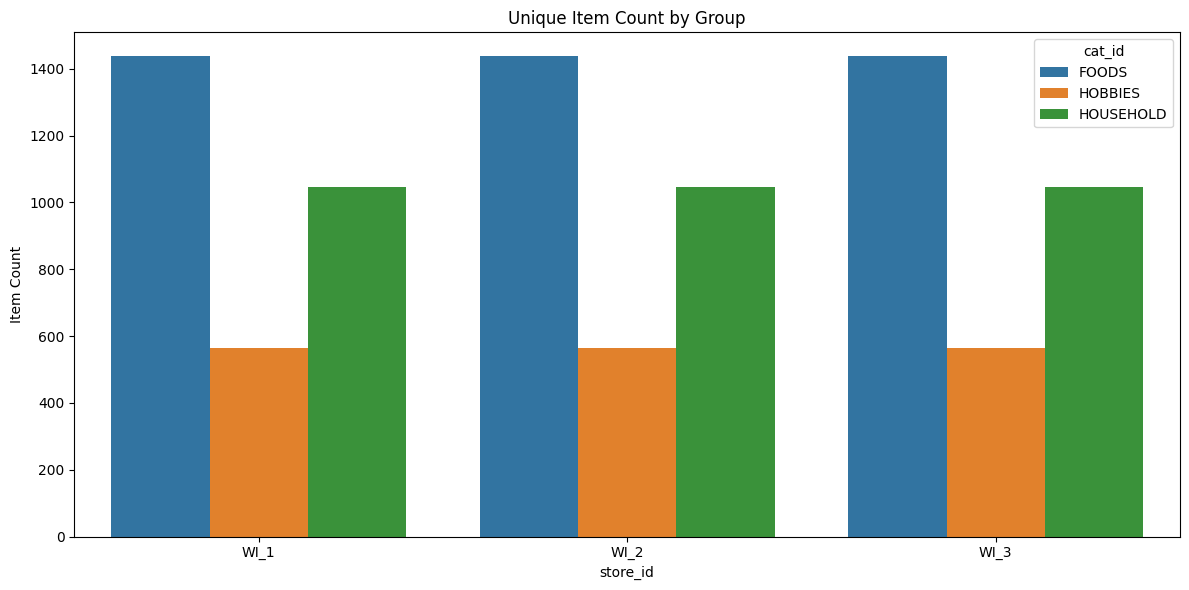

In [11]:
# Test data
states = ['CA', 'TX', 'WI']
for state in states:
    plot_unique_item_count(df_test, ['store_id', 'cat_id'], 'item_id', 'state_id', state)

### 2.3.3 Visualising 'sales revenue' over time

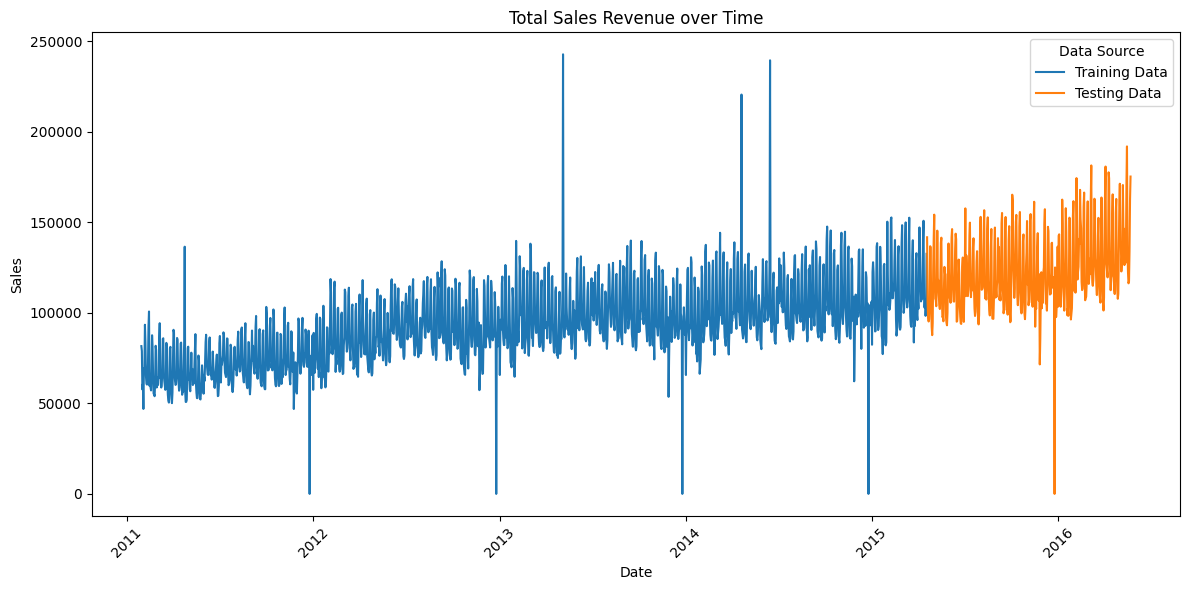

In [12]:
plot_time_series(df_train, 'date', 'sales_revenue', df_test, title='Total Sales Revenue over Time', xlabel='Date', ylabel='Sales')

### 2.3.4 Visualising Monthly sales revenue

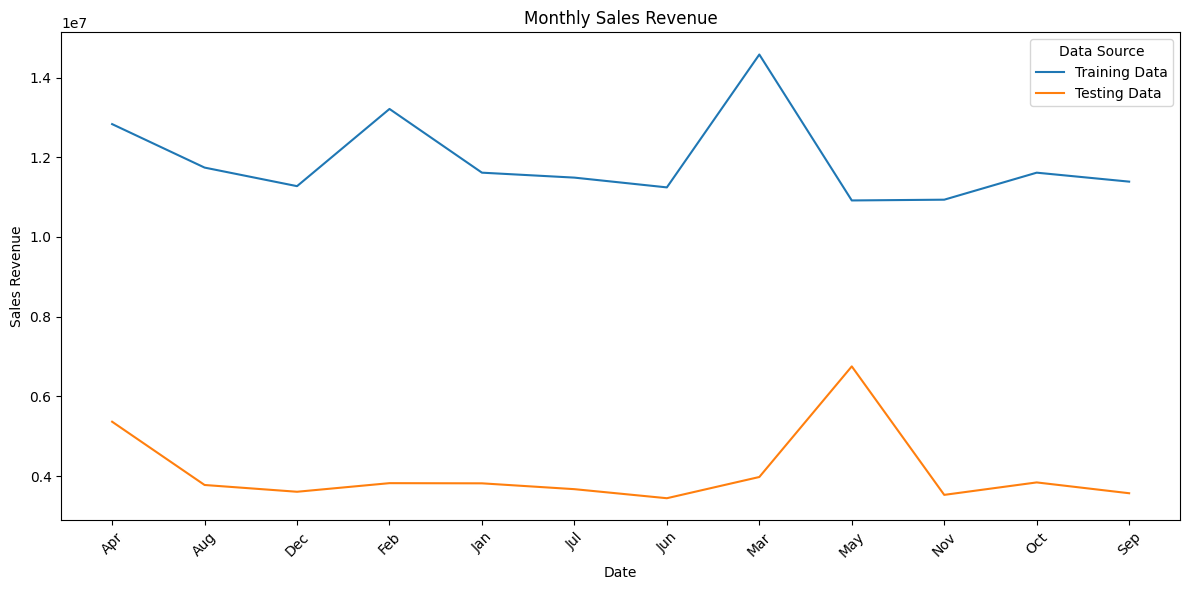

In [13]:
plot_time_series(df_train, 'month_name', 'sales_revenue', df_test, title='Monthly Sales Revenue', xlabel='Date', ylabel='Sales Revenue')


## 2.5 Feature Selection 

In [14]:
#Feature selection. Since the model is to predict the sales given date, item and store, choosing to have 
# 'day_name', 'month','store_id','debt_id'(which can be extracted from item_id later when captured thru UI)
columns_to_drop = ['id','item_id','cat_id','state_id','d','wm_yr_wk','day_index','sell_price','sales','event_type']
df_train = df_train.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   dept_id        object        
 1   store_id       object        
 2   date           datetime64[ns]
 3   day_name       object        
 4   month_name     object        
 5   sales_revenue  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.6+ GB


In [16]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160986 entries, 0 to 12160985
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   dept_id        object        
 1   store_id       object        
 2   date           datetime64[ns]
 3   day_name       object        
 4   month_name     object        
 5   sales_revenue  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 556.7+ MB


In [17]:
## Extracting the 'target' 
train_target = df_train.pop('sales_revenue')
y_test = df_test.pop('sales_revenue')

## 2.6 Feature Engineering - Add 'year' column since the sales revenue has gradually increased over the year and this can factor the year during prediction. 

In [18]:
# Create the 'year' column as a string in both dataframes
df_train['year'] = df_train['date'].dt.year.astype(str)
X_test['year'] = X_test['date'].dt.year.astype(str)

# Optionally, display the first few rows to confirm
print(df_train[['date', 'year']].head())
print(X_test[['date', 'year']].head())

        date  year
0 2011-01-29  2011
1 2011-01-30  2011
2 2011-01-31  2011
3 2011-02-01  2011
4 2011-02-02  2011
        date  year
0 2015-04-19  2015
1 2015-04-20  2015
2 2015-04-21  2015
3 2015-04-22  2015
4 2015-04-23  2015


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   dept_id     object        
 1   store_id    object        
 2   date        datetime64[ns]
 3   day_name    object        
 4   month_name  object        
 5   year        object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.6+ GB


In [20]:
df_train.head()

,dept_id,store_id,date,day_name,month_name,year
0,HOBBIES_1,CA_1,2011-01-29,Sat,Jan,2011
1,HOBBIES_1,CA_1,2011-01-30,Sun,Jan,2011
2,HOBBIES_1,CA_1,2011-01-31,Mon,Jan,2011
3,HOBBIES_1,CA_1,2011-02-01,Tue,Feb,2011
4,HOBBIES_1,CA_1,2011-02-02,Wed,Feb,2011


## 2.7 Split Datasets

In [21]:
# Ensure the data is sorted by date
df_train = df_train.sort_values('date')

# Define the split date
split_date = '2015-03-03'  

# Split the dataset based on the split date
X_train = df_train[df_train['date'] < split_date]
X_val = df_train[df_train['date'] >= split_date]

y_train = train_target[df_train['date'] < split_date]
y_val = train_target[df_train['date'] >= split_date]

In [22]:
X_train.shape

(33405677, 6)

In [23]:
X_val.shape

(1409497, 6)

In [25]:
#Free up some memory
del df_train
import gc
gc.collect()  # Force garbage collection

1212

## 2.8 Drop the 'date' feature 

In [26]:
X_train.drop(columns='date', inplace=True)
X_val.drop(columns='date', inplace=True)
X_test.drop(columns='date', inplace=True)

In [ ]:
## 2.7 Save the sets 

In [27]:
y_train_df = pd.DataFrame({'target': y_train})
y_val_df = pd.DataFrame({'target': y_val})
y_test_df = pd.DataFrame({'target': y_test})

# Training data
X_train.to_parquet('../../data/processed/X_train.parquet', index=False)
y_train_df .to_parquet('../../data/processed/y_train.parquet', index=False)

# Validation data
X_val.to_parquet('../../data/processed/X_val.parquet', index=False)
y_val_df.to_parquet('../../data/processed/y_val.parquet', index=False)

# Test data
X_test.to_parquet('../../data/processed/X_test.parquet', index=False)
y_test_df.to_parquet('../../data/processed/y_test.parquet', index=False)